In [1]:
import os
import sys

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data.fetcher import get_single_ticker
from src.data.features import FeatureEngineer
from src.models.baseline import OLSModel
from src.evaluation.backtest import backtest_signals
from src.data.fetcher import get_vix, get_risk_free_rate

In [2]:
start_date = "2015-01-01"
end_date = "2024-01-01"

print(f"Analyzing period: {start_date} to {end_date}")

Analyzing period: 2015-01-01 to 2024-01-01


In [3]:
spy = get_single_ticker("SPY", start=start_date, end=end_date, use_cache=True)
print(f"SPY loaded: {len(spy)} rows")

vix = get_vix(start_date, end_date)
rf = get_risk_free_rate(start_date, end_date)

print(f"VIX loaded: {len(vix)} rows")
print(f"RF loaded: {len(rf)} rows")

Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for SPY...
 Data for SPY cached at data/raw/SPY_1d.csv.
SPY loaded: 2264 rows
Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for ^VIX...
 Data for ^VIX cached at data/raw/^VIX_1d.csv.
Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for ^IRX...
 Data for ^IRX cached at data/raw/^IRX_1d.csv.
VIX loaded: 2264 rows
RF loaded: 2263 rows


In [4]:
#Volatility (VIX) and risk-free rate are included to capture market conditions and excess return dynamics
print("\nCreating features with VIX and RF...")

engineer = FeatureEngineer()

features_df = engineer.create_all_features(spy, vix, rf)

print("\nColumns avaliable :")
print(features_df.columns.tolist())

print("\nData overview with features")
features_df.head()


Creating features with VIX and RF...
Creating features...
Returns added
Momentum added
Volatility added
RSI added
Volume features added
VIX added
Risk-free rate added
Target created

Columns avaliable :
['adj_close', 'close', 'high', 'low', 'open', 'volume', 'return_1d', 'log_return_1d', 'return_5d', 'log_return_5d', 'return_20d', 'log_return_20d', 'sma_20d', 'price_to_sma_20', 'sma_50d', 'price_to_sma_50', 'ma_cross_20_50', 'volatility_20d', 'hl_range_20d', 'rsi_14', 'volume_ma_20', 'volume_ratio_20', 'vix', 'vix_change', 'rf', 'excess_return_1d', 'drift_20d', 'drift_60d', 'drift_120d', 'sigma_20d', 'sigma_60d', 'sigma_120d', 'drift_vol_ratio_20d', 'drift_vol_ratio_60d', 'vol_of_vol_20d', 'vol_of_vol_60d', 'sigma_regime', 'drift_mean_reversion', 'target_return_1d', 'target_direction_1d']

Data overview with features


,adj_close,close,high,low,open,volume,return_1d,log_return_1d,return_5d,log_return_5d,...,sigma_60d,sigma_120d,drift_vol_ratio_20d,drift_vol_ratio_60d,vol_of_vol_20d,vol_of_vol_60d,sigma_regime,drift_mean_reversion,target_return_1d,target_direction_1d
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,170.589600,205.429993,206.880005,204.179993,206.380005,121465900,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.018060,0
2015-01-05,167.508835,201.720001,204.369995,201.350006,204.169998,169632600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009419,0
2015-01-06,165.931091,199.820007,202.720001,198.860001,202.089996,209151400,-0.018060,-0.018225,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012461,1
2015-01-07,167.998795,202.309998,202.720001,200.880005,201.419998,125346700,-0.009419,-0.009464,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017745,1
2015-01-08,170.979904,205.899994,206.160004,203.990005,204.009995,147217800,0.012461,0.012384,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008014,0


In [5]:
print("Colonnes disponibles dans features_df:")
print(features_df.columns.tolist())

print("\n" + "="*60)
print("VIX présent ?", "vix" in features_df.columns)
print("VIX_change present ?", "vix_change" in features_df.columns)
print("RF present ?", "rf" in features_df.columns)
print("excess_return_1d present ?", "excess_return_1d" in features_df.columns)

if "vix" in features_df.columns:
    print(f"\nVIX: {features_df['vix'].notna().sum()} non-NaN values")
if "rf" in features_df.columns:
    print(f"RF: {features_df['rf'].notna().sum()} non-NaN values")

Colonnes disponibles dans features_df:
['adj_close', 'close', 'high', 'low', 'open', 'volume', 'return_1d', 'log_return_1d', 'return_5d', 'log_return_5d', 'return_20d', 'log_return_20d', 'sma_20d', 'price_to_sma_20', 'sma_50d', 'price_to_sma_50', 'ma_cross_20_50', 'volatility_20d', 'hl_range_20d', 'rsi_14', 'volume_ma_20', 'volume_ratio_20', 'vix', 'vix_change', 'rf', 'excess_return_1d', 'drift_20d', 'drift_60d', 'drift_120d', 'sigma_20d', 'sigma_60d', 'sigma_120d', 'drift_vol_ratio_20d', 'drift_vol_ratio_60d', 'vol_of_vol_20d', 'vol_of_vol_60d', 'sigma_regime', 'drift_mean_reversion', 'target_return_1d', 'target_direction_1d']

VIX présent ? True
VIX_change present ? True
RF present ? True
excess_return_1d present ? True

VIX: 2264 non-NaN values
RF: 2263 non-NaN values


In [6]:
#Candidate features are chosen based on economic intuition rather than automated feature selection
target_col = "target_return_1d"

candidate_features = [
    "return_1d",
    "return_5d",
    "return_20d",
    "log_return_1d",
    "price_to_sma_20d",
    "price_to_sma_50d",
    "volatility_20d",
    "rsi_14",
    "vix",
    "vix_change",
    "excess_return_1d"
]

feature_cols = [c for c in candidate_features if c in features_df.columns]

print("Selected features :")
print(feature_cols)

df_model = features_df.dropna(subset=[target_col] + feature_cols).copy()

X = df_model[feature_cols]
y = df_model[target_col]

print(f"Final size of dataset model : {X.shape[0]} observations, {X.shape[1]} features")

Selected features :
['return_1d', 'return_5d', 'return_20d', 'log_return_1d', 'volatility_20d', 'rsi_14', 'vix', 'vix_change', 'excess_return_1d']
Final size of dataset model : 2241 observations, 9 features


In [7]:
#Time-based split is used to simulate a real out-of-sample forecasting exercise
split_date = "2020-01-01"

X_train = X[X.index < split_date]
y_train = y[y.index < split_date]

X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]

print(f"train : {X_train.index.min().date} -> {X_train.index.max().date()} ({len(X_train)} obs)")
print(f"test : {X_test.index.min().date} -> {X_test.index.max().date()} ({len(X_test)} obs)")

train : <bound method Timestamp.date of Timestamp('2015-02-03 00:00:00')> -> 2019-12-31 (1236 obs)
test : <bound method Timestamp.date of Timestamp('2020-01-02 00:00:00')> -> 2023-12-28 (1005 obs)


In [8]:
#HAC standard errors are used to account for heteroskedasticity and autocorrelation in returns
ols = OLSModel(use_hac=True, maxlags=5)
ols.fit(X_train, y_train, add_constant=True, standardize=True)

ols.summary()

coef_df = ols.get_coefficients()
coef_df

sig_features = ols.get_significant_features(alpha=0.05)
print(f"\n{"="*60}")
print(f"Significant features (alpha=0.05): {sig_features}")
print(f"{"="*60}")

OLS Regression Results
                            OLS Regression Results                            
Dep. Variable:       target_return_1d   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                    0.8738
Date:                Sat, 20 Dec 2025   Prob (F-statistic):              0.548
Time:                        20:22:43   Log-Likelihood:                 4151.1
No. Observations:                1236   AIC:                            -8282.
Df Residuals:                    1226   BIC:                            -8231.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const            

In [9]:
#A fixed threshold in basis points is used to ensure signals exceed realistic transaction cost levels
y_pred_test = ols.predict(X_test)
predictions = pd.Series(y_pred_test, index=X_test.index, name="y_pred")

print("="*70)
print("PREDICTIONS OVERVIEW")
print("="*70)
print(predictions.head())
print(f"\nPredictions stats:")
print(predictions.describe())

print(f"\nPrediction ranges:")
print(f"  Positive predictions: {(predictions > 0).sum()} ({(predictions > 0).mean()*100:.1f}%)")
print(f"  Negative predictions: {(predictions < 0).sum()} ({(predictions < 0).mean()*100:.1f}%)")
print(f"  Very positive (>0.1%): {(predictions > 0.001).sum()} ({(predictions > 0.001).mean()*100:.1f}%)")
print(f"  Very negative (<-0.1%): {(predictions < -0.001).sum()} ({(predictions < -0.001).mean()*100:.1f}%)")

threshold_bps = 5
threshold = threshold_bps / 10000

signals_conservative = pd.Series(0, index=predictions.index, name="conservative")
signals_conservative[predictions > threshold] = 1

print(f"\n{'='*70}")
print(f"STRATEGY 1: CONSERVATIVE (pred > {threshold_bps} bps)")
print(f"{'='*70}")
print(f"Time in market: {signals_conservative.mean()*100:.1f}%")
print(f"Signal distribution:")
print(signals_conservative.value_counts(normalize=True))

upper_quantile = predictions.quantile(0.40)

signals_quantile = pd.Series(0, index=predictions.index, name="quantile")
signals_quantile[predictions > upper_quantile] = 1

print(f"\n{'='*70}")
print(f"STRATEGY 2: QUANTILE-BASED (Top 30%)")
print(f"{'='*70}")
print(f"Threshold: {upper_quantile:.6f}")
print(f"Time in market: {signals_quantile.mean()*100:.1f}%")
print(f"Signal distribution:")
print(signals_quantile.value_counts(normalize=True))

signals_always = pd.Series(1, index=predictions.index, name="always")
signals_always[predictions < -0.001] = 0

print(f"\n{'='*70}")
print(f"STRATEGY 3: ALWAYS INVESTED (cash only if pred < -0.1%)")
print(f"{'='*70}")
print(f"Time in market: {signals_always.mean()*100:.1f}%")
print(f"Signal distribution:")
print(signals_always.value_counts(normalize=True))

vix_values = features_df.loc[X_test.index, 'vix']

signals_vix = signals_quantile.copy()
signals_vix[vix_values > 25] = 0

print(f"\n{'='*70}")
print(f"STRATEGY 4: QUANTILE + VIX TIMING")
print(f"{'='*70}")
print(f"VIX stats in test set:")
print(f"  Mean VIX: {vix_values.mean():.2f}")
print(f"  Max VIX: {vix_values.max():.2f}")
print(f"  VIX > 25: {(vix_values > 25).sum()} days ({(vix_values > 25).mean()*100:.1f}%)")
print(f"  VIX > 20: {(vix_values > 20).sum()} days ({(vix_values > 20).mean()*100:.1f}%)")
print(f"\nAfter VIX filter:")
print(f"  Time in market: {signals_vix.mean()*100:.1f}%")
print(f"  Signal distribution:")
print(signals_vix.value_counts(normalize=True))

print(f"\n{'='*70}")
print("SIGNAL COMPARISON")
print(f"{'='*70}")
print(f"Conservative vs Quantile different: {(signals_conservative != signals_quantile).sum()} signals")
print(f"Quantile vs Always different: {(signals_quantile != signals_always).sum()} signals")
print(f"Quantile vs VIX different: {(signals_quantile != signals_vix).sum()} signals")

signals_final = signals_quantile

print(f"\n{'='*70}")
print("SELECTED STRATEGY FOR BACKTEST: QUANTILE (Top 30%)")
print(f"{'='*70}")
print(f"First 10 signals:")
print(signals_final.head(10))

PREDICTIONS OVERVIEW
date
2020-01-02    0.000404
2020-01-03    0.000523
2020-01-06    0.000335
2020-01-07    0.000156
2020-01-08    0.000761
Name: y_pred, dtype: float64

Predictions stats:
count    1005.000000
mean        0.001618
std         0.002706
min        -0.000817
25%         0.000545
50%         0.001087
75%         0.001816
max         0.049141
Name: y_pred, dtype: float64

Prediction ranges:
  Positive predictions: 952 (94.7%)
  Negative predictions: 53 (5.3%)
  Very positive (>0.1%): 546 (54.3%)
  Very negative (<-0.1%): 0 (0.0%)

STRATEGY 1: CONSERVATIVE (pred > 5 bps)
Time in market: 76.7%
Signal distribution:
conservative
1    0.767164
0    0.232836
Name: proportion, dtype: float64

STRATEGY 2: QUANTILE-BASED (Top 30%)
Threshold: 0.000847
Time in market: 60.0%
Signal distribution:
quantile
1    0.6
0    0.4
Name: proportion, dtype: float64

STRATEGY 3: ALWAYS INVESTED (cash only if pred < -0.1%)
Time in market: 100.0%
Signal distribution:
always
1    1.0
Name: proportio

In [10]:
from scipy.stats import spearmanr
ic, p_value = spearmanr(predictions, y_test)
print(f"\n Information coefficient : {ic:.4f} (p_value : {p_value:.6f})")


 Information coefficient : 0.0565 (p_value : 0.073350)


Multiple rule-based strategies are tested to assess the economic usefulness of model predictions


Backtesting Conservative (>5bps)...

Backtesting Quantile (Top 30%)...

Backtesting Always Invested...

Backtesting Quantile + VIX...

STRATEGY COMPARISON
                      Total Return (%)  Sharpe Ratio  Max DD (%)  \
Conservative (>5bps)             26.63          0.38      -30.87   
Quantile (Top 30%)               41.76          0.53      -30.87   
Always Invested                  46.29          0.53      -34.10   
Quantile + VIX                   29.88          0.79      -11.83   
Buy & Hold (SPY)                 46.31          0.53      -34.10   

                      Time in Market (%)  Num Trades  
Conservative (>5bps)               76.72       247.0  
Quantile (Top 30%)                 60.00       300.0  
Always Invested                   100.00         0.0  
Quantile + VIX                     34.13       252.0  
Buy & Hold (SPY)                  100.00         0.0  


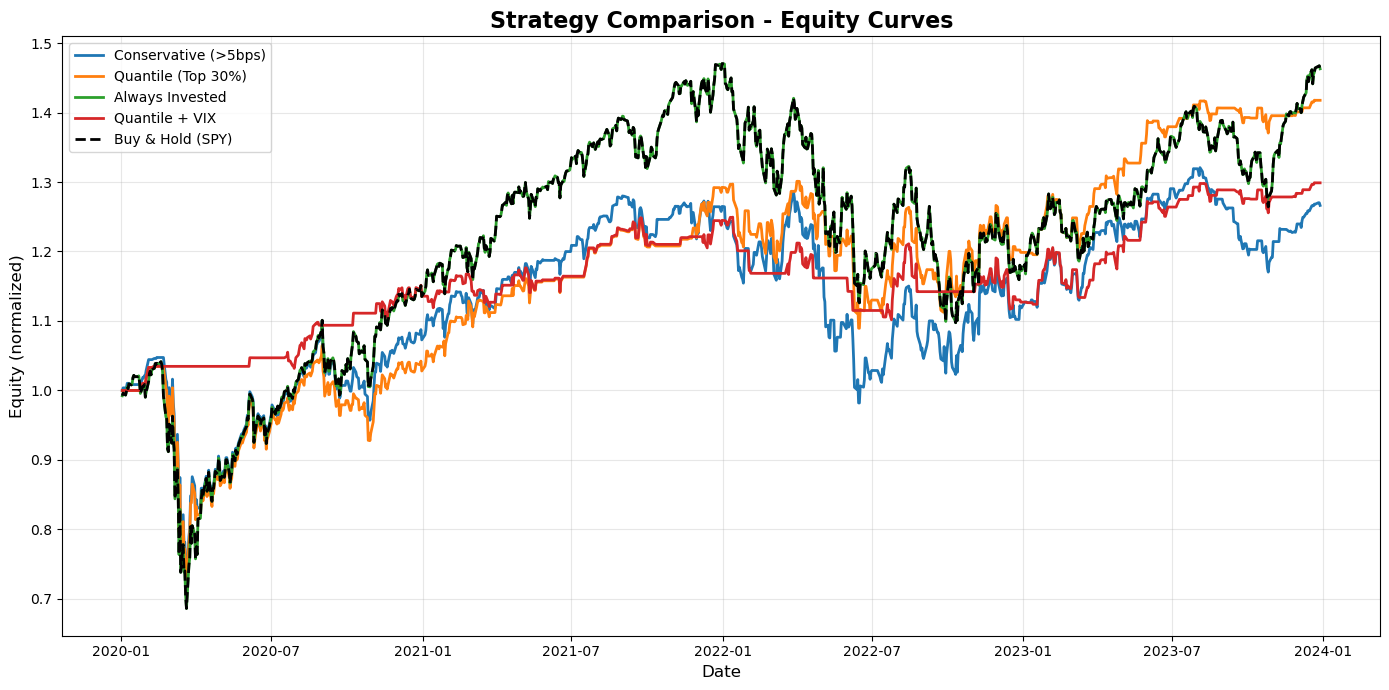

In [11]:
#Transaction costs are included to avoid overstating performance
strategies = {
    "Conservative (>5bps)": signals_conservative,
    "Quantile (Top 30%)": signals_quantile,
    "Always Invested": signals_always,
    "Quantile + VIX": signals_vix,
}

backtest_results = {}
results_summary = {}

for name, sigs in strategies.items():
    print(f"\nBacktesting {name}...")
    bt_obj = backtest_signals(y_test, sigs, trading_cost_bps=1.0, starting_capital=1.0)
    
    backtest_results[name] = bt_obj
    
    ret = bt_obj.strategy_returns
    cum_ret = (1 + ret).cumprod()
    
    results_summary[name] = {
        "Total Return (%)": (cum_ret.iloc[-1] - 1) * 100,
        "Sharpe Ratio": (ret.mean() / ret.std()) * np.sqrt(252) if ret.std() > 0 else 0,
        "Max DD (%)": ((cum_ret - cum_ret.expanding().max()) / cum_ret.expanding().max()).min() * 100,
        "Time in Market (%)": sigs.mean() * 100,
        "Num Trades": sigs.diff().abs().sum()
    }

#Buy & Hold serves as a passive benchmark to evaluate whether active strategies add value
results_summary["Buy & Hold (SPY)"] = {
    "Total Return (%)": ((1 + y_test).cumprod().iloc[-1] - 1) * 100,
    "Sharpe Ratio": (y_test.mean() / y_test.std()) * np.sqrt(252),
    "Max DD (%)": (((1 + y_test).cumprod() - (1 + y_test).cumprod().expanding().max()) / (1 + y_test).cumprod().expanding().max()).min() * 100,
    "Time in Market (%)": 100.0,
    "Num Trades": 0
}

comparison = pd.DataFrame(results_summary).T

print("\n" + "="*80)
print("STRATEGY COMPARISON")
print("="*80)
print(comparison.round(2))

fig, ax = plt.subplots(figsize=(14, 7))

for name, bt_obj in backtest_results.items():
    ax.plot(bt_obj.equity_curve, label=name, linewidth=2)

ax.plot((1 + y_test).cumprod(), label="Buy & Hold (SPY)", 
        linestyle="--", linewidth=2, color="black")

ax.set_title("Strategy Comparison - Equity Curves", fontsize=16, fontweight="bold")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Equity (normalized)", fontsize=12)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
strategy_name = "Conservative (>5bps)"

bt = backtest_results[strategy_name]

print(f"Using {strategy_name} for detailed analysis")

Using Conservative (>5bps) for detailed analysis


Daily stats (test set) :

Strategy :
count    1005.000000
mean        0.000326
std         0.013443
min        -0.109424
25%        -0.003623
50%         0.000000
75%         0.005916
max         0.090603
dtype: float64

Benchmark :
count    1005.000000
mean        0.000482
std         0.014306
min        -0.109424
25%        -0.006096
50%         0.000786
75%         0.007649
max         0.090603
Name: returns, dtype: float64


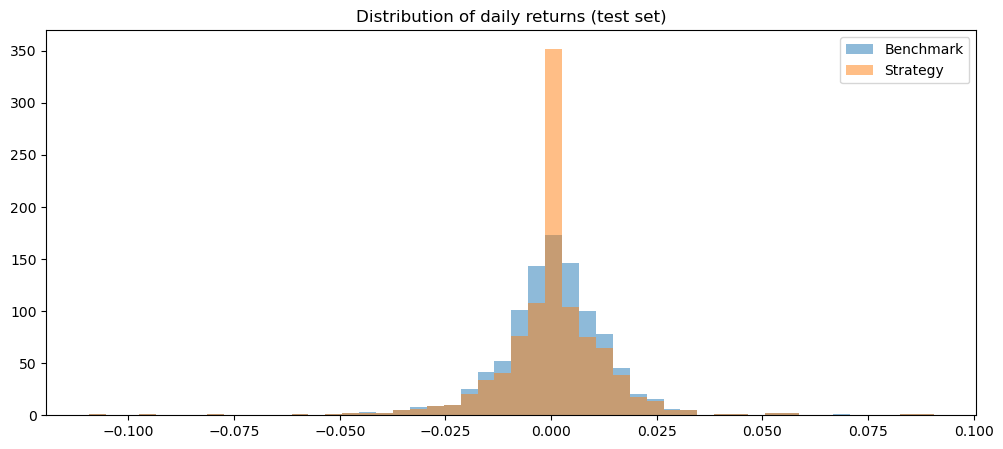

In [13]:
bt_returns = bt.strategy_returns
bench_returns = bt.benchmark_returns

print("Daily stats (test set) :")
print("\nStrategy :")
print(bt_returns.describe())

print("\nBenchmark :")
print(bench_returns.describe())

plt.figure(figsize=(12,5))
plt.hist(bench_returns, bins=50, alpha=0.5, label="Benchmark")
plt.hist(bt_returns, bins=50, alpha=0.5, label="Strategy")
plt.legend()
plt.title("Distribution of daily returns (test set)")
plt.show()


In [14]:
from scipy import stats

sharpe_strategy = (bt_returns.mean() / bt_returns.std()) * np.sqrt(252)
sharpe_benchmark = (bench_returns.mean() / bench_returns.std()) * np.sqrt(252)

print(f"\nPerformance Metrics :")
print(f"Strategy Sharpe : {sharpe_strategy:.3f}")
print(f"Benchmark Sharpe : {sharpe_benchmark:.3f}")

excess_returns = bt_returns - bench_returns
info_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)
print(f"Information ratio : {info_ratio:.3f}")

win_rate = (bt_returns > 0).sum() / len(bt_returns)
print(f"Win rate : {win_rate*100:.1f}%")

cumulative = (1 + bt_returns).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_dd = drawdown.min()
print(f"Max drawdown : {max_dd*100:.2f}%")


Performance Metrics :
Strategy Sharpe : 0.385
Benchmark Sharpe : 0.534
Information ratio : -0.504
Win rate : 40.5%
Max drawdown : -30.87%
